# Necessary Library Imports

In [1]:
from platform import python_version
print("Python version " + python_version())
import openslide
print("Openslide version " + openslide.__version__)

import xmltodict as xmltodict
import os
from tqdm.notebook import tqdm as tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from skimage.draw import polygon
import numpy as np
from PIL import Image

Python version 3.9.13
Openslide version 1.2.0


## Defined functions

In [2]:
# Given the large images contaning more background then tissue, the tiles will only be allowed if they do contain tissue
def whitePercentage(slice_):
    hist = slice_.split()[1].histogram()
    return sum(hist[220:]) / sum(hist)

def reCoordinate(x: int, y: int, offset_x: int, offset_y: int, mpp_x: float, mpp_y: float, wsiDimension_x: int, wsiDimension_y: int):
    x = ((x - offset_x) / 1000 / mpp_y + wsiDimension_x / 2)
    y = ((y - offset_y) / 1000 / mpp_x + wsiDimension_y / 2)
    return int(x), int(y)

## Tile and Mask Generation

Files for grad 1: 14, ['20Rig023838010105 - 2020-10-31 14.47.56.ndpi', '20Rig024449010105 - 2020-10-31 14.23.37.ndpi', '20Rig024304010101 - 2020-10-31 14.28.12.ndpi', '20Rig023838010101 - 2020-10-31 14.54.41.ndpi', '20Rig024449010110 - 2020-10-31 14.21.11.ndpi', '20Rig022133010105 - 2020-10-31 15.29.34.ndpi', '20Rig023838010110 - 2020-10-31 14.45.35.ndpi', '20Rig024304010105 - 2020-10-31 14.26.44.ndpi', '20Rig024449010101 - 2020-10-31 14.24.58.ndpi', '20Rig024304010110 - 2020-10-31 14.30.09.ndpi', '20Rig029176010101 - 2020-07-03 09.02.52.ndpi', '20Rig026655010110 - 2020-10-23 17.28.20.ndpi', '20Rig028691010105 - 2020-10-09 16.32.21.ndpi', '20Rig026655010105 - 2020-10-23 17.27.01.ndpi']


  0%|          | 0/14 [00:00<?, ?it/s]

File 20Rig023838010105 - 2020-10-31 14.47.56.ndpi in grad 1
Annotation class 1
Annotation class 1
Annotation class 1
Annotation class 1
Annotation class 1
Annotation class 1
Annotation class 1


  0%|          | 0/4620 [00:00<?, ?it/s]

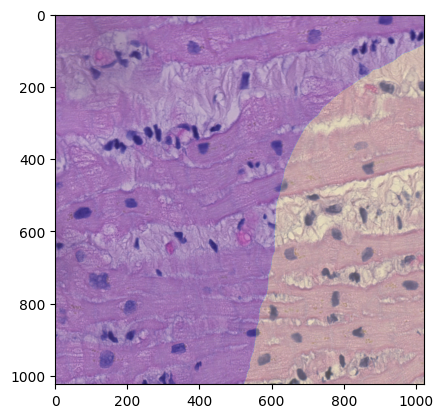

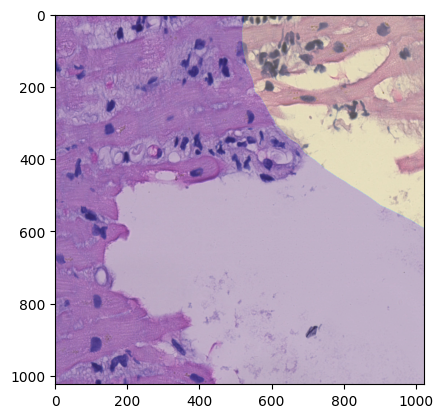

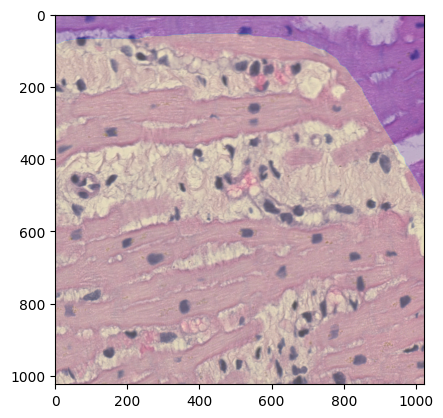

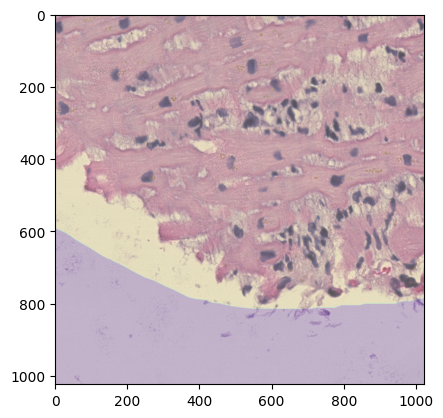

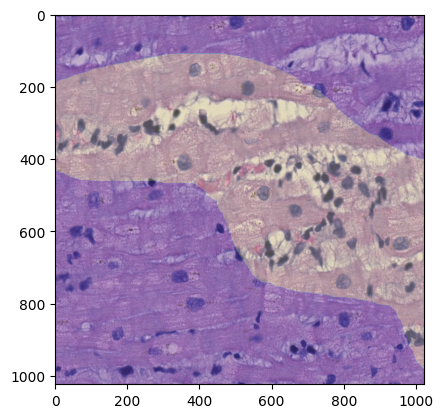

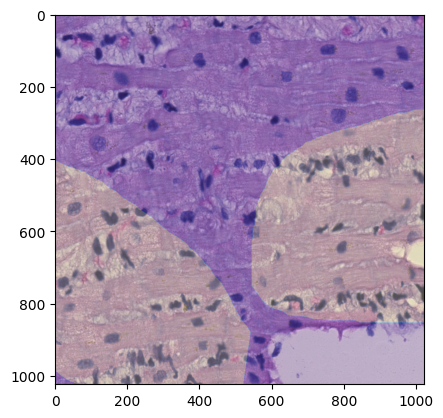

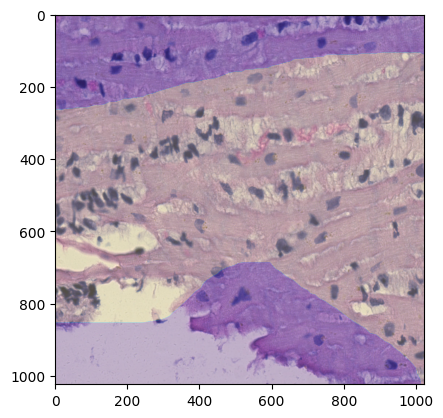

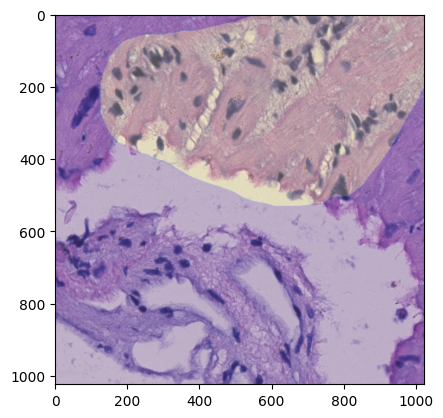

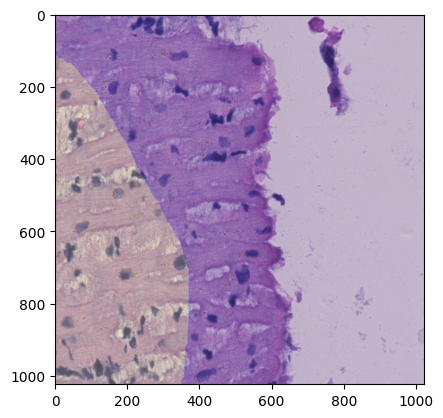

KeyboardInterrupt: 

In [3]:
# Dictionary of the colors referring to the annotations done by pathologist
colorDict = {'#000000': 1, '#ff0000': 2, '#00ff00': 3}
# #000000 = black, Infiltrate WoD
# #ff0000 = red, Infiltrate WD
# #00ff00 = green, Quilty
# #ffff00 = yellow, Severe Rejection

# Dictionary of the possible classes an annotation by pathologist can occur in
classDict = {1: 'Infiltrate WoD', 2: 'Infiltrate WD', 3: 'Quilty'}
# classDict(1) = Infiltrate WoD, infiltrate without damage to the myocytes
# classDict(2) = Infiltrate WD, infiltrate with damage to the myocytes (myocytolysis)
# classDict(3) = Quilty, Quilty lesion
# classDict(4) = Severe rejection, Severe Rejection

# Params for tile creation
tileWidth = tileHeight = 1024
stride = 1024
maxWhite = 0.7
classThreshold = 0.15

for grad in ['1','2','3']:
    basePath = f'/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/WSI Slides/Grad {grad}/'  # Path for the WSI
    files = os.listdir(basePath)  # List of files in basePath
    files = [file[:-5] for file in files if file.endswith('.ndpa')]  # Remove annotation files from the list files in directory basePath
    print(f'Files for grad {grad}: {len(files)}, {files}')

    for file in tqdm(files):
        # Import wsi(whole slide image) file NDPI and the corresponding annotation file NDPA
        fileId = file
        wsiFile = os.path.join(basePath, file)
        wsi = openslide.OpenSlide(wsiFile)
        annotationFile = Path(wsiFile).with_suffix(".ndpi.ndpa")

        # Params for wsi using openslide
        wsiDimensions = wsi.level_dimensions[0] # Dimensions for wsi
        mppX = float(wsi.properties["openslide.mpp-x"]) # Microns(micrometers) per pixel for WSI
        mppY = float(wsi.properties["openslide.mpp-y"]) # Microns(micrometers) per pixel for WSI
        offsetX = int(wsi.properties["hamamatsu.XOffsetFromSlideCentre"]) # Offset from slide center
        offsetY = int(wsi.properties["hamamatsu.YOffsetFromSlideCentre"]) # Offset from slide center

        print(f"File {fileId} in grad {grad}")

        # Annotation from NDPA file
        with open(annotationFile) as fd:
            doc = xmltodict.parse(fd.read())
            annotations = doc['annotations']['ndpviewstate']

        wsiMask = np.zeros(wsiDimensions, dtype=np.uint8) # Create mask array of 0 points over the wsi dimensions

        for annotation in annotations:
            skip = False
            try:
                assert annotation['coordformat'] == 'nanometers' # Check if coordinate format in annotationFile equals nanometers
            except Exception as e:
                skip = True
            if not skip:
                assert annotation['annotation']['closed'] == '1'
                color = annotation['annotation']['@color']
                points = [(int(_['x']), int(_['y'])) for _ in annotation['annotation']['pointlist']['point']] # Add points from annotationFile to the array points
                points = [reCoordinate(_[0], _[1], offsetX, offsetY, mppX, mppY, wsiDimensions[0], wsiDimensions[1]) for _ in points] # Recoordinate points using the created function reCoordinate
                segmentationMask = polygon(np.array(points)[:,0], np.array(points)[:,1]) # Shape of the segmentation mask from the annotated points
                wsiMask[segmentationMask] = colorDict[color] # Insert annotated mask color number from colorDict in the wsiMask array
                print(f"Annotation class {colorDict[color]}")

        # Tile building
        tiles = [(x, y) for x in range(0, wsiDimensions[0], stride) for y in range(0, wsiDimensions[1], stride)] # Array of tiles over wsi dimensions with stride
        for tile in tqdm(tiles):
            if not ((tile[0] + tileWidth > wsiDimensions[0]) or (tile[1] + tileHeight > wsiDimensions[1]) or (tile[0] < 0) or (tile[1] < 0)): # Check tile boundaries with wsi dimensions
                tilePatch = wsi.read_region(tile, 0, (tileWidth, tileHeight)) # Create tile using openslide.read_region
                if whitePercentage(tilePatch) < maxWhite: # Check if tile contains more tissue than white background using whitePercentage function
                    maskTile = wsiMask[tile[0]:tile[0] + tileWidth, tile[1]:tile[1] + tileHeight] # Create mask tile array from wsiMask array using tile params
                    maskTilePatch = Image.fromarray(maskTile.T) # Create mask image from maskTile array

                    #Tile saving
                    tileClass = np.unique(maskTile)# Create array of unique numbers of maskTile array (used for classifying tile when saving)
                    for classId in tileClass:
                        classFraction = (maskTile==classId).sum() / (maskTile.shape[0]*maskTile.shape[1])
                        if classId in classDict and classFraction > classThreshold: # Check if keys from classDict is element of created unique array over maskTile
                            plt.imshow(tilePatch)
                            plt.imshow(maskTilePatch, alpha=0.2)
                            plt.show()
                            className = classDict[classId]
                            #tilePatch.save(f'/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Tiles/1024x1024/Images/{className}/{fileId}_{tile[0]}_{tile[1]}_{grad}.png')
                            #maskTilePatch.save(f'/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Tiles/1024x1024/Labels/{className}/{fileId}_{tile[0]}_{tile[1]}_{grad}.png')
                        #elif tileClass.sum() == 0:
                            #tilePatch.save(f'/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Tiles/Images/None/{fileId}_{tile[0]}_{tile[1]}_{grad}.png')
                            #maskTilePatch.save(f'/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Tiles/Labels/None/{fileId}_{tile[0]}_{tile[1]}_{grad}.png')